# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

Загрузим необходимые библиотеки.

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns 

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

import time

from sklearn.metrics import ( accuracy_score,confusion_matrix,recall_score,
                             precision_score,roc_auc_score,f1_score,roc_curve,
                             mean_squared_error, make_scorer)

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings("ignore")

Загрузим файл и изучим файл.

In [4]:
data = pd.read_csv('/Users/alexander/Documents/Python/DataSets/Определение стоимости автомобилей/autos.csv')

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
display(pd.DataFrame({'Кол-во заполненных значений': data.notna().sum(), '% пропусков': round(data.isna().mean()*100, 2)}))
len_data_raw = len(data)
display('размер исходной таблицы до проработки данных:', len_data_raw)

,Кол-во заполненных значений,% пропусков
DateCrawled,354369,0.00
Price,354369,0.00
VehicleType,316879,10.58
RegistrationYear,354369,0.00
Gearbox,334536,5.60
Power,354369,0.00
Model,334664,5.56
Kilometer,354369,0.00
RegistrationMonth,354369,0.00
FuelType,321474,9.28


'размер исходной таблицы до проработки данных:'

354369

### Поиск ошибок

У столбцов DateCrawled, DateCreated, LastSeen неверный тип данных, но эти столбыцы не будут использоваться для предсказаний, достаточно столбца RegistrationYear, который является по сути возрастом автомобиля. Необходимо проверить нет ли случайно данных, где год регистрации меньше года публикации объяваления. Естесмтвенно регистрация должна произойти раньше публикации. Если такие данные есть - это ошибка и их нужно удалить. 

In [8]:
display(data.loc[data['RegistrationYear'] > pd.to_datetime(data['DateCreated']).dt.year].head())
print('Кол-во объявлений где год регистрации объявления меньше года публикации объявления:' , 
    data.loc[data['RegistrationYear'] > pd.to_datetime(data['DateCreated']).dt.year].count()['DateCreated'])
print('Доля объявлений где год регистрации объявления меньше года публикации объявления:' , 
    data.loc[data['RegistrationYear'] > pd.to_datetime(data['DateCreated']).dt.year].count()['DateCreated'] / len(data) *100, '%')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37


Кол-во объявлений где год регистрации объявления меньше года публикации объявления: 14530
Доля объявлений где год регистрации объявления меньше года публикации объявления: 4.100245788993958 %


Данных достаточно много - целых 4%. Стоит обратить на это внимание сервису по продаже автомобилей. Удалим ошибочные данные.

In [9]:
print('Размер таблицы до удаления ошибок', data.shape)
data = data.loc[data['RegistrationYear'] <= pd.to_datetime(data['DateCreated']).dt.year]
print('Размер таблицы после удаления ошибок', data.shape)

Размер таблицы до удаления ошибок (354369, 16)
Размер таблицы после удаления ошибок (339839, 16)


### Поиск и удаление дубликатов

In [10]:
def unique_values(df):
    for column in df.columns:
        print('Уникальные значения столбца:', column)
        print(df[column].unique())
        print()

In [11]:
unique_values(data)

Уникальные значения столбца: DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Уникальные значения столбца: Price
[  480 18300  9800 ... 12395 18429 10985]

Уникальные значения столбца: VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения столбца: RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 1997 1990 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000 1992
 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971 1987 1986
 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961 1960
 1966 1975 1963 1964 1954 1958 1967 1959 1956 1000 1941 1500 1962 1929
 1957 1940 1949 1937 1951 1800 1953 1234 1933 1400 1950 1948 1952 1200
 1932 1255 1942 1935 1936 1923 1930 1001 1944 1943 1934 1938 1688 1253
 1928 1919 1600 1039 1300 1931 1915 1920 1602 1947 1927 1946]

Уникальные значения с

In [12]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,339839.000000,339839.000000,339839.000000,339839.000000,339839.000000,339839.0,339839.000000
mean,4470.719223,2002.322862,111.018918,128063.847881,5.755440,0.0,50604.718128
std,4545.989553,13.946854,186.976116,37928.471721,3.708625,0.0,25806.788923
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30169.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49492.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Изучив полный отчет по уникальным значениям вместе с отчетом по описательной статистике было замечено следующее:
- Есть товары с ценой 0, мы все знаем что такого не бывает, или это 'пианино', которое для доставки еще как то вручную нужно спустить с 5ого этажа многоэтажки, поэтому предлагаю удалить подробные товары, тем более что цена это еще и целевой признак. Более того возможно есть авто по 1 евро, потому стоит изучить все данные по ценам детальнее, чтобы установить нижний предел. 
- Есть пропуски по полю VehicleType (6.76%). Поля заполненные как other нужно заменить на NaN.
- Год регистрации авто (RegistrationYear) имеет значения с 1000 по 1999 год, хотя согласно открытым источникам первый номер был выдан только в 1989г, а полноценная регистраци началась после принятия Венской конвенции, подписанной рядом Евпропейских стран, в 1968, но активно применятся начала с 1977, потому считаю возможным удалить как ошибки все объявления до 1977г. Пропусков по полю нет.
- Столбец Gearbox имеет 2 типа значений, есть пропуски 5,29%. 
- Мощность в л.с. (Power) имеет значения от 0 до 20000, что абсолютно невозможно, самый мощный найденный автомобиль имеет мощность вышее 4000л.с.6 но его точно нет в списке. Самый маломощный автомобиль найденный в открытых источниках имеет мощность 4.2 л.с., а самый мощный около 1500 л.с., потому оставим объявления со значениеми от 4 до 1500 л.с. Пропусков нет.
- Столбец Model иммеет много значений, есть пропуски, нет возможности их заполнить, их придется удалить.
- Пробег судя по уникальным значениям заполняется в виде поля для выбора в диапозоне от 5000км до 150000км, странно, я наделся найти Mersedes с двигателем "миллионником". Я уверен, что автомобилей с пробегом более 150тыс очень много. Если существует статистика среднегодового пробега по стране, можно предположить, что поле год регистрации RegistrationYear имеет высокую корреляцию с пробегом автомобиля. Пропусков по пробегу нет. 
- Поле месяц регистрации имеет 0 значения, что по сути есть NaN, не думаю что это поле нужно использовать для обучения модели, потому что год более важен. 
- FuelType имеет ряд значени, есть пропуски, попробуем заполнить их через словарь уникальных значений Model, Power и FuelType. Обычно у каждой конкретной модели разные типы двигателя (бензин и дизель) имеют разную мощность.
- По полю Brand пропусков нет. 
- Поле Repaired так же является булевым типом данных, имеет пропуски. Можно предположить, что пропуски оставили те, кто не ремонтировал авто.
- Поле с числом фото NumberOfPictures по всем объявлениям равно 0, потому этот столбец удалим из признаков. 
- Поля DateCreated, PostalCode, LastSeen нас не интересуют потому что не будут участвовать в расчете модели. 

Далее исключим из таблицы ошибочные и малореалистичные значения. 

Изучим график изменения цен. Нам нужно найти нижний предел цен, потому что ранее приняли решение не использовать 0 значения.

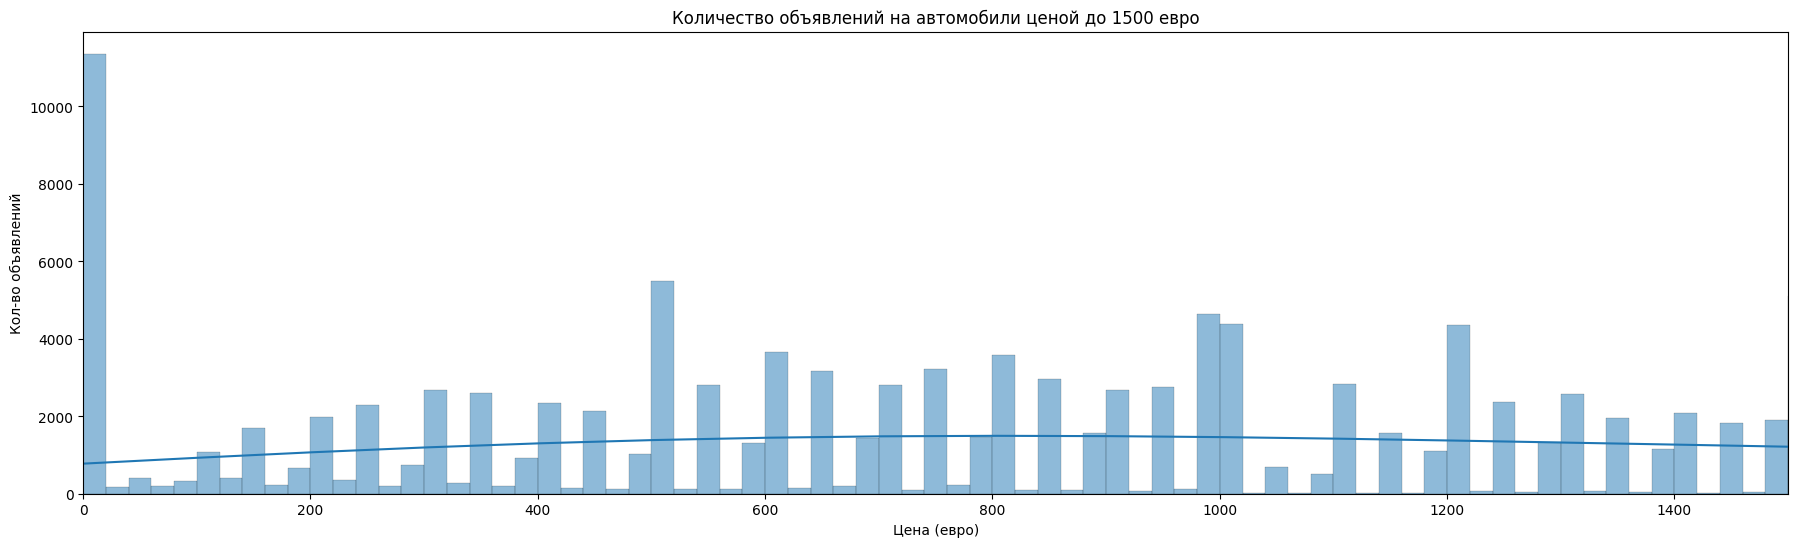

In [13]:
plt.figure(figsize=(22, 6))

g = sns.histplot(data['Price'], bins=1000, kde=True) 
g.set_xlim(0, 1500)   #1500 получено путем перебора для наилучшей визуализации
g.set(xlabel='Цена (евро)', ylabel = 'Кол-во объявлений', title='Количество объявлений на автомобили ценой до 1500 евро')   
plt.show()

In [14]:
display(data.loc[data['Price'] < 200].head(15))
print()
print('Число объвлений с ценой менее 200:', len(data.loc[data['Price'] < 200]))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
79,2016-03-17 18:52:56,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes,2016-03-17 00:00:00,0,78315,2016-04-05 03:45:22
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
145,2016-03-06 21:38:00,150,NaN,1985,NaN,0,100,150000,4,petrol,audi,NaN,2016-03-06 00:00:00,0,87616,2016-04-07 02:16:59
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,57627,2016-03-26 11:17:50



Число объвлений с ценой менее 200: 16550


Исходя из графика я бы взял 200 евро как разумеую цену за автомобиль. Очистим данные по цене.

In [15]:
data = data.loc[data['Price'] >= 200]

По столбцам VehicleType, FuelType, Model необходимо зазаменить other на NaN.

In [16]:
data = data.replace('other', np.NaN)

Удалим пропуски по полю VehicleType.

In [17]:
data = data.dropna(subset='VehicleType')

Удалим все объявления с годом регистрации до 1977г.

In [18]:
data = data.loc[data['RegistrationYear'] >= 1977]

По столбцу Gearbox имеется 2 типа значений, есть пропуски 5,29%. Я считаю что не заполнить данное поле могли лишь те, кто не знает о том какой тип коробки передач у них остановлен, а это вероятнее всего те, кто имеют коробку автомат, тот кто водит механику знает что это механика (и часто даже гордиться этим, потому этот пункт не могли пропустить владельцы механики). Помимо этого заменим эти данные на категориальный тип данных.

In [19]:
data = data.replace(['auto', 'manual'], [1, 0])
data['Gearbox'] = data['Gearbox'].fillna(1)
data['Gearbox'] = data['Gearbox'].astype('int')
data = data.rename(columns={'Gearbox': 'GearboxAuto'}) #заменим наименование столбца чтобы не запутаться


Теперь удалим ошибки по полю Power, оставим только значения в диапозоне от 4 до 1500 л.с. 

In [20]:
data = data.loc[(data['Power'] <= 1500) & (data['Power'] >= 4)]


Удалим пропуски по столбцу Model.

In [21]:
data = data.dropna(subset='Model')

Попробуем создать словарь уникальных значений для заполнения столбца FuelType.

FuelType имеет ряд значени, есть пропуски, попробуем заполнить их через словарь уникальных значений Model, Power и FuelType. Обычно у каждой конкретной модели разные типы двигателя (бензин и дизель) имеют разную мощность.

In [22]:
unique_cars = data[['Model', 'Power', 'FuelType']]    
unique_cars = unique_cars.drop_duplicates().dropna() 
unique_cars

,Model,Power,FuelType
2,grand,163,gasoline
3,golf,75,petrol
4,fabia,69,gasoline
5,3er,102,petrol
6,2_reihe,109,petrol
...,...,...,...
353946,primera,103,petrol
354097,espace,149,petrol
354222,golf,173,petrol
354299,a6,168,gasoline


Я выводил этот словарь уникальных значений в полном виде и после детального изучения решил, что этот метод не сработает, ниже покажу на примере одной из моделей.

In [23]:
unique_cars.loc[unique_cars['Model'] == 'a1'].sort_values('Power')

,Model,Power,FuelType
31629,a1,83,petrol
2176,a1,85,petrol
93,a1,86,petrol
2838,a1,90,gasoline
123127,a1,90,petrol
152909,a1,92,petrol
15797,a1,95,petrol
306784,a1,100,petrol
301679,a1,101,gasoline
254,a1,105,gasoline


Обратим внимание на строки 4 и 5, Model	и Power совпадают (а1 и 90) а FuelType отличается, поэтому не получается словарь уникальных значений, а это лишь 1 модель по которой я визуально заметил этот аспект, сколько таких же аспектова по другим модель сказать сложно, но что такая ситуация может повториться это факт. Придется удалить отсутвующие значения. 

In [24]:
data = data.dropna(subset='FuelType')

Удалим пропуски по столбцу Repaired, а также сделаем переменную категориальной.

In [25]:
data['Repaired'] = data['Repaired'].fillna(0).replace(['yes', 'no'], [1, 0]) 

Все данные почищены, осталось удалить дубликаты, если таковые имеются.

In [26]:
print('Кол-во дубликатов:', len(data)-len(data.drop_duplicates()))

Кол-во дубликатов: 4


Удалим дубликаты их совсем немного.

In [27]:
data = data.drop_duplicates().reset_index(drop=True)

Изучим как изменился объем очищенной таблицы.

In [28]:
display(pd.DataFrame({'Кол-во заполненных значений': data.notna().sum(), '% пропусков': round(data.isna().mean()*100, 2)}))
print('размер исходной таблицы до проработки данных:', len_data_raw)
print('размер исходной таблицы после проработки данных:', len(data))
print('% удаленных строк от изначального объема:', (len_data_raw - len(data))/ len(data) *100, '%')

,Кол-во заполненных значений,% пропусков
DateCrawled,243052,0.0
Price,243052,0.0
VehicleType,243052,0.0
RegistrationYear,243052,0.0
GearboxAuto,243052,0.0
Power,243052,0.0
Model,243052,0.0
Kilometer,243052,0.0
RegistrationMonth,243052,0.0
FuelType,243052,0.0


размер исходной таблицы до проработки данных: 354369
размер исходной таблицы после проработки данных: 243052
% удаленных строк от изначального объема: 45.79966426937446 %


In [29]:
data.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,GearboxAuto,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-14 12:52:21,9800,suv,2004,1,163,grand,125000,8,gasoline,jeep,0,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
1,2016-03-17 16:54:04,1500,small,2001,0,75,golf,150000,6,petrol,volkswagen,0,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
2,2016-03-31 17:25:20,3600,small,2008,0,69,fabia,90000,7,gasoline,skoda,0,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
3,2016-04-04 17:36:23,650,sedan,1995,0,102,3er,150000,10,petrol,bmw,1,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
4,2016-04-01 20:48:51,2200,convertible,2004,0,109,2_reihe,150000,8,petrol,peugeot,0,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
5,2016-04-04 23:42:13,14500,bus,2014,0,125,c_max,30000,8,petrol,ford,0,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
6,2016-03-26 19:54:18,2000,sedan,2004,0,105,3_reihe,150000,12,petrol,mazda,0,2016-03-26 00:00:00,0,96224,2016-04-06 10:45:34
7,2016-04-07 10:06:22,2799,wagon,2005,0,140,passat,150000,12,gasoline,volkswagen,1,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17
8,2016-03-15 22:49:09,999,wagon,1995,0,115,passat,150000,11,petrol,volkswagen,0,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16
9,2016-03-21 12:57:01,17999,suv,2011,0,190,navara,70000,3,gasoline,nissan,0,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42


Пришлось удалить достаточно большой объем данных 48%, но к сожалению это вопрос к системе, в которой заполнялись данные по объявлениям.

Мы провели предоработку данных, заменили, где возмождно пропуски, где невозможно удалили, избавились от ошибок и дубликатов.

Теперь данные готовы для построения модели.

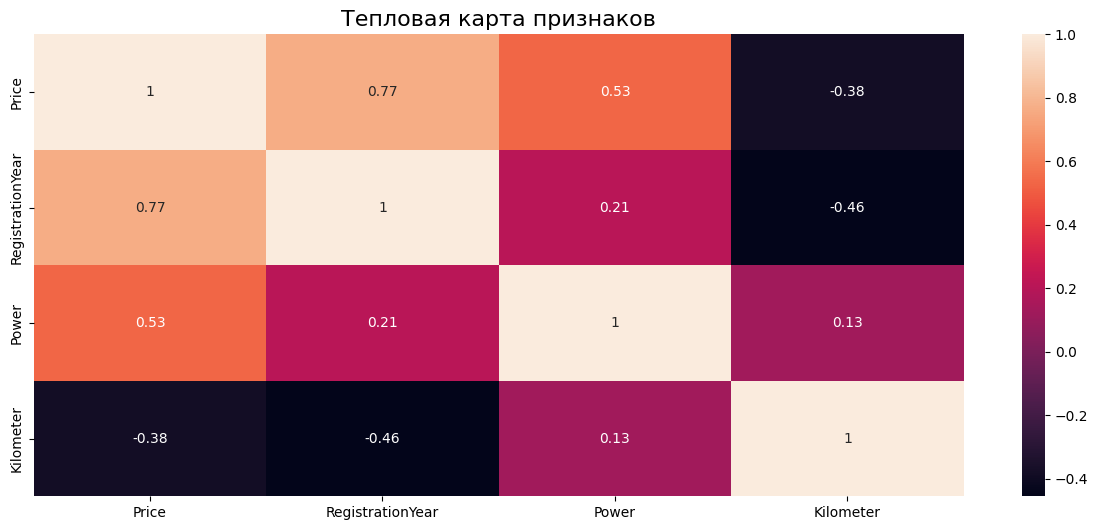

In [30]:
plt.figure(figsize= (15, 6))
# удаляем 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Repaired', 'GearboxAuto' 
# меняем с дефолтного метода на коеффициент корреляции рангов Спирмена
sns.heatmap(data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Repaired', 'GearboxAuto']).corr(method='spearman'), annot = True)  

plt.title('Тепловая карта признаков', fontsize=16)

plt.show()

Заметна большая прямая зависимость между годом регистрации и ценой автомобиля, что вполне логично, чем авто новее тем стоит больше. Также заметна обратная зависимость между годом регистрации и пробегом. Также существует прмая зависомость между мощностью и ценой, что так же более чем логично, мощнейшие спорткары стоят дорожде малолитражек.

### Кодирование категориальных, масштабирование численных признаков и разделение выборким


Прежде чем обучить модели преобразуем категориальные признаки в численные с помощью техники Прямого кодирования (One-Hot Encoding).

In [34]:
categories_all = ['VehicleType','Model','FuelType','Brand']

data_ohe = data.copy()

data_ohe[categories_all] = OrdinalEncoder().fit_transform(data_ohe[categories_all])

data_ohe.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,GearboxAuto,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-14 12:52:21,9800,5.0,2004,1,163,117.0,125000,8,2.0,14.0,0,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
1,2016-03-17 16:54:04,1500,4.0,2001,0,75,116.0,150000,6,5.0,37.0,0,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
2,2016-03-31 17:25:20,3600,4.0,2008,0,69,101.0,90000,7,2.0,31.0,0,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [35]:


categories_all = ['VehicleType', 'Model', 'FuelType','Brand']
for category in categories_all:
    #data[category] = data[category].astype('str') 
    data[category] = data[category].astype('category') # работает только с LGMBRegressor
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243052 entries, 0 to 243051
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DateCrawled        243052 non-null  object  
 1   Price              243052 non-null  int64   
 2   VehicleType        243052 non-null  category
 3   RegistrationYear   243052 non-null  int64   
 4   GearboxAuto        243052 non-null  int64   
 5   Power              243052 non-null  int64   
 6   Model              243052 non-null  category
 7   Kilometer          243052 non-null  int64   
 8   RegistrationMonth  243052 non-null  int64   
 9   FuelType           243052 non-null  category
 10  Brand              243052 non-null  category
 11  Repaired           243052 non-null  int64   
 12  DateCreated        243052 non-null  object  
 13  NumberOfPictures   243052 non-null  int64   
 14  PostalCode         243052 non-null  int64   
 15  LastSeen           243052 non-null

Разделим данные на обучающую валидационную выборки.

In [36]:
target = data['Price']
features = data.drop(
        ['Price', 'DateCrawled', 'DateCreated',
         'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.40, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.50, random_state=12345)

#добавляю ту же процедуру для данных OHE

target = data_ohe['Price']
features = data_ohe.drop(
        ['Price', 'DateCrawled', 'DateCreated',
         'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

features_train_ohe, features_temp, target_train_ohe, target_temp = train_test_split(
    features, target, test_size=0.40, random_state=12345)

features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
    features_temp, target_temp, test_size=0.50, random_state=12345)


#проверим размеры
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(145831, 9)
(145831,)
(48610, 9)
(48610,)
(48611, 9)
(48611,)


Смаштабируем числовые признаки.

In [37]:
numeric = ['RegistrationYear','Power','Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

# добавим для тестовой
features_test[numeric] = scaler.transform(features_test[numeric])


# добавим для данных OHE
scaler.fit(features_train[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])



display(features_train.head())

display(features_valid.head())

,VehicleType,RegistrationYear,GearboxAuto,Power,Model,Kilometer,FuelType,Brand,Repaired
199610,bus,2.171954,0,-0.357102,caddy,-2.973317,gasoline,volkswagen,0
227282,sedan,0.699937,1,0.736146,3er,-1.323562,gasoline,bmw,0
81904,sedan,0.515935,0,-0.106192,1er,-0.086246,petrol,bmw,0
9958,wagon,-0.588077,0,0.252249,6_reihe,0.601152,petrol,mazda,0
60788,bus,0.515935,0,1.273809,b_klasse,-0.086246,petrol,mercedes_benz,1


,VehicleType,RegistrationYear,GearboxAuto,Power,Model,Kilometer,FuelType,Brand,Repaired
133288,sedan,1.435946,0,1.112510,5er,0.601152,gasoline,bmw,0
70331,small,1.619948,0,0.270171,swift,-1.323562,petrol,suzuki,0
197612,small,-0.588077,0,-1.145674,clio,0.601152,petrol,renault,0
11168,sedan,1.803950,0,-0.303336,leon,-1.873480,gasoline,seat,0
52403,small,-2.244096,0,-0.572167,civic,0.601152,petrol,honda,0


Данные полностью готовы для построения и оценки моделей.

## Обучение моделей

Напишем функцию метрики RMSE и функцию, которая будет фиксировать время обучения модели, предсказания и RMSE по тестовой выборке.

In [38]:
# оформим функцию по расчету метрики RMSE
def RMSE(target,predict):
    MSE = mean_squared_error(target, predict)
    return MSE ** 0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [39]:
def model_time (model,features_train, target_train,features_test, target_test,title):
    start1 = time.time()
    model.fit(features_train, target_train)
    finish1 = time.time() - start1 #время обучения модели
    start2  = time.time()
    predict = model.predict(features_test)
    finish2 = time.time() - start2 #время нахождения предсказания
    result = [finish1,finish2,RMSE(target_test, predict)] #запишем данные в финальную таблицу в 3 столбца: время обучения, время предсказания RMSE по тестовой выборке
    print (f'\nРеультат работы модели {title}')
    print ('\nВремя обучения модели,сек.:',result[0])
    print ('Время прогнозирования,сек.:',result[1])
    print ('\nРазмер метрики RMSE по тестовой выборке:',result[2])
    return result;


### Линейная Регрессия

Начнем с простой модели линейной регрессии.

In [40]:
LR_info = model_time(LinearRegression(),
                        features_train_ohe, target_train_ohe,
                        features_valid_ohe, target_valid_ohe,
                        'LinearRegression')


Реультат работы модели LinearRegression

Время обучения модели,сек.: 0.04538297653198242
Время прогнозирования,сек.: 0.005632877349853516

Размер метрики RMSE по тестовой выборке: 2736.189121915185


RMSE крайневысокая, проверим другие модели.

### Случайный лес

In [41]:
rfr_random_grid = {'n_estimators': [10, 50, 200, 1000, 2000],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [10, 20, 50, 100, None],
               'min_samples_split': [1, 2, 4],
               'min_samples_leaf': [2, 5, 10],
               'bootstrap': [True, False]}
rfr_random_grid

{'n_estimators': [10, 50, 200, 1000, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 50, 100, None],
 'min_samples_split': [1, 2, 4],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False]}

Проверим для начала модель с гиперпараметрами по умолчанию. 

In [42]:
RFR_default_info = model_time(RandomForestRegressor(),
                        features_train_ohe, target_train_ohe,
                        features_valid_ohe, target_valid_ohe,
                    'RandomForestRegressor')


Реультат работы модели RandomForestRegressor

Время обучения модели,сек.: 20.232661962509155
Время прогнозирования,сек.: 1.554401159286499

Размер метрики RMSE по тестовой выборке: 1513.7018600883773


Теперь найдем наилучшие гиперпараметры с помощью RandomizedSearchCV.

In [43]:
%%time
rfr = RandomForestRegressor()
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = rfr_random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfr_random.fit(features_valid_ohe, target_valid_ohe)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=10; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=10; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.1s
[CV] END bootstrap=False, max_depth=100, max_features

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 50, 100, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [1, 2, 4],
                                        'n_estimators': [10, 50, 200, 1000,
                                                         2000]},
                   random_state=42, verbose=2)

10 минут заняло время поисков наилучших гиперпараметров из предложденных, что крайне долго.

In [44]:
print('Лучшие гиперпараметры модели Random Forest Regressor:')
rfr_random.best_params_

Лучшие гиперпараметры модели Random Forest Regressor:


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': False}

Набор параметров найден, применим его.

In [45]:
RFR_info = model_time(RandomForestRegressor(random_state=12345, criterion = 'squared_error',**rfr_random.best_params_),
                    features_train_ohe, target_train_ohe,
                    features_valid_ohe, target_valid_ohe,
                    'RandomForestRegressor')


Реультат работы модели RandomForestRegressor

Время обучения модели,сек.: 193.2096881866455
Время прогнозирования,сек.: 16.127733945846558

Размер метрики RMSE по тестовой выборке: 1459.4665493244338


Время обучения занимает длительное время, RMSE имеет хороший показатель.

### LGBMRegressor

Найдем наилучшие гиперпараметры с помощью GridSearchCV.

In [46]:
lgbm_random_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_samples': [1, 5, 10]
}


estimator = lgb.LGBMRegressor(objective='regression', 
                              random_state=12345)

lgbm_grid = GridSearchCV(estimator=estimator, 
                     param_grid=lgbm_random_grid,
                     cv=3, 
                     n_jobs=-1, 
                     scoring='neg_root_mean_squared_error')
lgbm_grid.fit(features_valid, target_valid)

print('Лучшие гиперпараметры модели LGBM:')
lgbm_grid.best_params_


Лучшие гиперпараметры модели LGBM:


{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_samples': 5,
 'n_estimators': 150,
 'subsample': 0.7}

Набор параметров найден, применим его.

In [47]:
LGBMR_info = model_time(lgb.LGBMRegressor(objective='regression', random_state=12345,**lgbm_grid.best_params_),
                        features_train, target_train,
                        features_valid, target_valid,
                    'LGBMRegressor')


Реультат работы модели LGBMRegressor

Время обучения модели,сек.: 0.8930850028991699
Время прогнозирования,сек.: 0.06573104858398438

Размер метрики RMSE по тестовой выборке: 1504.5800282478342


Модель обучается и находит прдсказания очень быстро, RMSE имеет также хороший показатель.

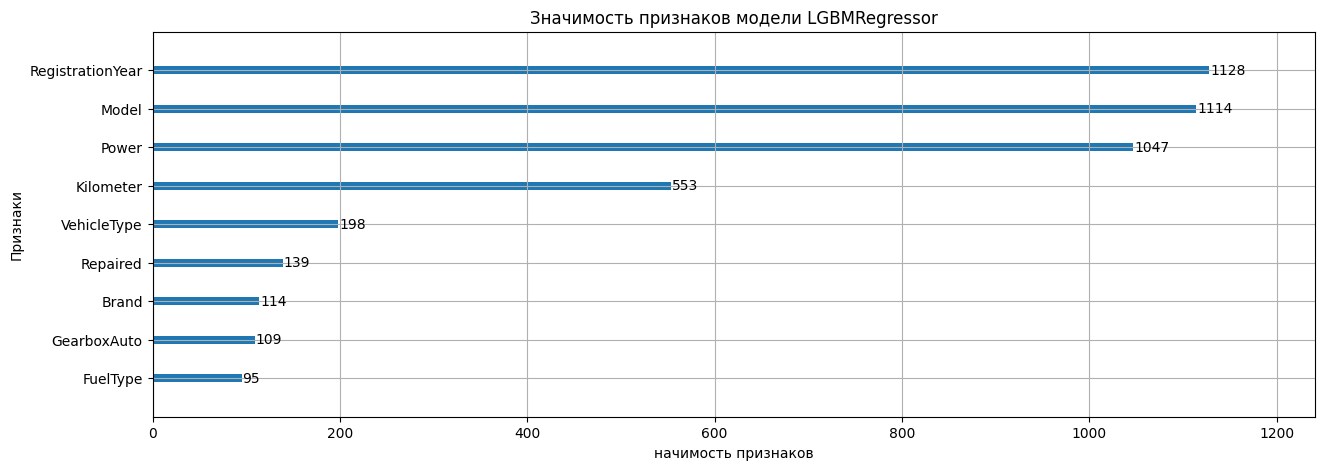

In [48]:
lgb_fit = lgb.LGBMRegressor(objective='regression', random_state=12345, **lgbm_grid.best_params_).fit(features_train, target_train)
lgb.plot_importance(lgb_fit, figsize=(15,5),max_num_features=12)
plt.title('Значимость признаков модели LGBMRegressor')
plt.xlabel('начимость признаков')
plt.ylabel('Признаки')
plt.show()

Схожие данные мы видели на тепловой карте: самый значимый показатель год регисрации, следующим идет мощность, пробег.

### CatBoostRegressor

Ввиду того, что я не смогу локально уствновить библиотеку CatBoost (какая то непонятная ошибка) расчет этой модели я делал отдельно в Jupiter Notebook. Сюда перенес код, закоментировал и создал переменную с данными посчитанными там.

In [49]:
%%time

catboost_random_grid = {'depth': [4,5,6,7,8,9, 10],
                 'learning_rate': [0.01,0.02,0.03,0.04],
                  'iterations': [10, 20,30,40,50,60,70,80,90, 100]
                 }

CBR = CatBoostRegressor(cat_features=categories_all)

Grid_CBR = GridSearchCV(estimator=CBR, param_grid = catboost_random_grid, cv = 3, n_jobs=-1)
Grid_CBR.fit(features_valid, target_valid)

print("\n Лучшие гиперпараметры модели CatBoost:\n",Grid_CBR.best_params_)

0:	learn: 4523.2701591	total: 64.8ms	remaining: 584ms
0:	learn: 4584.0536676	total: 88.2ms	remaining: 794ms
0:	learn: 4491.8111086	total: 71ms	remaining: 639ms
0:	learn: 4578.6747378	total: 91.5ms	remaining: 823ms
1:	learn: 4554.1028142	total: 93.9ms	remaining: 376ms
0:	learn: 4608.8838821	total: 76.4ms	remaining: 687ms
0:	learn: 4580.8263733	total: 105ms	remaining: 942ms
0:	learn: 4548.5743442	total: 81.1ms	remaining: 730ms
0:	learn: 4521.3728703	total: 86.2ms	remaining: 776ms
1:	learn: 4579.5478096	total: 82ms	remaining: 328ms
1:	learn: 4551.4454310	total: 109ms	remaining: 438ms
1:	learn: 4435.6490138	total: 109ms	remaining: 438ms
1:	learn: 4520.8018385	total: 108ms	remaining: 430ms
2:	learn: 4522.8283263	total: 115ms	remaining: 267ms
2:	learn: 4463.6342968	total: 115ms	remaining: 268ms
1:	learn: 4375.5258356	total: 95.3ms	remaining: 381ms
1:	learn: 4435.9147131	total: 102ms	remaining: 408ms
2:	learn: 4268.9326633	total: 99.9ms	remaining: 233ms
3:	learn: 4407.0370007	total: 121ms	rem

In [55]:
CBR_info = model_time(CatBoostRegressor(random_state=12345, cat_features=categories_all, **Grid_CBR.best_params_),
                        features_train, target_train,
                        features_valid, target_valid,'CBR')

0:	learn: 4502.2676507	total: 44.1ms	remaining: 4.37s
1:	learn: 4368.1586526	total: 77ms	remaining: 3.77s
2:	learn: 4240.7783181	total: 91.2ms	remaining: 2.95s
3:	learn: 4120.0381168	total: 136ms	remaining: 3.26s
4:	learn: 4004.3130035	total: 155ms	remaining: 2.94s
5:	learn: 3894.1414087	total: 186ms	remaining: 2.92s
6:	learn: 3788.8064692	total: 199ms	remaining: 2.65s
7:	learn: 3686.5265994	total: 214ms	remaining: 2.46s
8:	learn: 3589.7784562	total: 227ms	remaining: 2.29s
9:	learn: 3497.6804436	total: 240ms	remaining: 2.16s
10:	learn: 3409.0174659	total: 253ms	remaining: 2.04s
11:	learn: 3326.7394961	total: 265ms	remaining: 1.94s
12:	learn: 3247.8684458	total: 296ms	remaining: 1.98s
13:	learn: 3174.2649075	total: 310ms	remaining: 1.9s
14:	learn: 3102.9515538	total: 323ms	remaining: 1.83s
15:	learn: 3036.0618488	total: 335ms	remaining: 1.76s
16:	learn: 2972.6235692	total: 347ms	remaining: 1.69s
17:	learn: 2911.9528455	total: 358ms	remaining: 1.63s
18:	learn: 2853.7321006	total: 375ms	r

## Анализ моделей

In [56]:
models_summary = pd.DataFrame([LR_info, RFR_info, LGBMR_info, CBR_info, RFR_default_info], 
             columns=['Время обучения', 'Время предсказания', 'RMSE тестовая выборка'], 
             index=['LinearRegression', 'RandomForest', 'LGBMRegressor', 'CatBoost', 'RandomForest без подбора гиперпараметров'])

models_summary = models_summary.astype('int64').sort_values(by='RMSE тестовая выборка')

models_summary

,Время обучения,Время предсказания,RMSE тестовая выборка
RandomForest,193,16,1459
LGBMRegressor,0,0,1504
RandomForest без подбора гиперпараметров,20,1,1513
CatBoost,2,0,1674
LinearRegression,0,0,2736


In [57]:
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=12345,**lgbm_grid.best_params_)
lgb_model.fit(features_train, target_train)

predict = lgb_model.predict(features_test)

lgb_model_RMSE = RMSE(target_test,predict)

lgb_model_RMSE


1494.5174746424602

## Вывод

Линейная регрессия отпала сраза из за сверх высокого RMSE. Самый высокий показатель RMSE у модели 'RandomForest без подбора гиперпараметров', чуть ниже модель RandomForest с подбором параметров, но по ней и самая низкая скорость обучения и предсказания, поиск параметров для этой модели занял 10 мин. LGBMRegressor - оказывается самой оптимальной моделью и по скорости и по RMSE. Время CatBoost некорректно, но даже с учетом уменьшения времени показатель RMSE у модели LGBMRegressor выше. 